# Baseball Savant Pitch Selection Algorithm - Data Prep

Name(s): Connor Vucovich, Doruk Ozar, and Taylor LaMantia

Class: CSCI 349 - Intro to Data Mining  

Section: 11am - 1

Semester: Spring 2024

Instructors: Brian King, Joshua Stough

---

Import necessary packages

In [252]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier
from mlxtend.frequent_patterns import apriori, association_rules

---
# Problem Description
---

*Summarize the problem in this cell.*

**ANSWER:**
The goal of this project is to develop a machine learning algorithm that can classify the description (outcome) of a baseball pitch based on various features such as pitch speed, spin rate, and movement. The dataset contains information about pitches thrown by various pitchers in Major League Baseball, including the pitch type, release speed, spin rate, and movement of the pitch. By training a machine learning model on this data, we aim to classify the description (outcome) of a given pitch based on its characteristics such as speed, roation, pitch type, spin rate and etc.

---
# Data - Exploration & Preprocessing
---

*What data are you using to understand the problem? Describe the data in a very general sense. 
Where did it come from? You should understand what every observation in the data represents, 
and what each variable represents.*

**ANSWER:** 

We are using baseball track man data from Major League Baseball’s official data storage facility. This data contains the outcome of every single pitch thrown in the MLB this past year and the metrics of the pitch as well, such as the velocity of the pitch toward home, the extension the pitcher gets off of the mound toward home upon release, the amount of spin on the ball as it is released by the pitcher, the direction of the spin on the ball as it leaves the pitchers hand, the horizontal movement on the ball as it approaches the batter in feet, the vertical movement on the ball as it approaches the batter in feet, and the effective speed which take the extension the pitcher into account and adjusts the perceived velocity that the batter would see based on this distance reduction. 


Read in baseball dataframe

In [253]:
# Combine parts of a file path for portability across operating systems
path = os.path.join('..', 'data', 'savant_data__2_.csv')
# Read a CSV file into a DataFrame, using the specified path
df_pitches = pd.read_csv(path)
# Set the index of the DataFrame to the 'player_name' column to allow for easier data access by player name
df_pitches.set_index('player_name', inplace=True)

In [254]:
df_pitches.info() # display the data types of each column

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 91 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pitch_type                       11925 non-null  object 
 1   game_date                        11925 non-null  object 
 2   release_speed                    11925 non-null  float64
 3   release_pos_x                    11925 non-null  float64
 4   release_pos_z                    11925 non-null  float64
 5   batter                           11925 non-null  int64  
 6   pitcher                          11925 non-null  int64  
 7   events                           3015 non-null   object 
 8   description                      11925 non-null  object 
 9   spin_dir                         0 non-null      float64
 10  spin_rate_deprecated             0 non-null      float64
 11  break_angle_deprecated           0 non-null      float64
 12  bre

In [255]:
df_pitches.head(10) # display the first 10 rows of the DataFrame

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,spin_dir,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
player_name,,,,,,,,,,,,,,,,,,,,,
"Bello, Brayan",SL,2024-04-14,86.8,-1.79,5.07,543305,678394,single,hit_into_play,NaN,...,3,2,3,2,3,Standard,Standard,50.0,-0.074,0.793
"Bello, Brayan",CH,2024-04-14,83.3,-1.87,5.05,543305,678394,NaN,called_strike,NaN,...,3,2,3,2,3,Standard,Standard,246.0,0.000,-0.098
"Bello, Brayan",SI,2024-04-14,96.0,-1.81,4.96,543305,678394,NaN,swinging_strike,NaN,...,3,2,3,2,3,Standard,Standard,247.0,0.000,-0.091
"Bello, Brayan",CH,2024-04-14,84.8,-1.99,5.08,543305,678394,NaN,ball,NaN,...,3,2,3,2,3,Standard,Standard,256.0,0.000,0.056
"Bello, Brayan",SL,2024-04-14,85.5,-1.83,5.13,543305,678394,NaN,ball,NaN,...,3,2,3,2,3,Standard,Standard,27.0,-0.027,0.044
"Bello, Brayan",SI,2024-04-14,95.8,-1.69,5.02,621493,678394,single,hit_into_play,NaN,...,3,2,3,2,3,Standard,Standard,243.0,-0.041,0.287
"Bello, Brayan",SL,2024-04-14,86.8,-1.55,5.18,621493,678394,NaN,foul,NaN,...,3,2,3,2,3,Standard,Standard,56.0,0.000,0.000
"Bello, Brayan",CH,2024-04-14,85.6,-1.77,4.96,621493,678394,NaN,foul,NaN,...,3,2,3,2,3,Standard,Standard,251.0,0.000,0.000
"Berríos, José",SI,2024-04-14,93.7,-1.88,5.62,607732,621244,field_out,hit_into_play,NaN,...,4,0,4,0,4,Standard,Standard,223.0,0.004,-0.065


Replace occurences of 'hit_into_play' in the 'description' column with NaN. Fill missing values in the 'description' column with corresponding values from the 'events' column. Drop the 'events' column from the DataFrame.

In [256]:
# Create a copy of the df_pitches DataFrame to clean and manipulate the data without altering the original data
df_pitches_cleaned = df_pitches
# Replace occurrences of 'hit_into_play' in the 'description' column with NaN (not a number) values
df_pitches_cleaned['description'].replace('hit_into_play', np.nan, inplace=True)
# Fill any NaN values in the 'description' column with corresponding values from the 'events' column
df_pitches_cleaned['description'] = df_pitches_cleaned['description'].fillna(df_pitches_cleaned['events'])
# Drop the 'events' column from the DataFrame as it is no longer needed after merging its data into 'description'
df_pitches_cleaned.drop('events', axis=1, inplace=True)
# Display the first 10 rows of the cleaned DataFrame to verify changes and see the cleaned data
df_pitches_cleaned.head(10)


C:\Users\810cl\AppData\Local\Temp\ipykernel_16172\1670979213.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pitches_cleaned['description'].replace('hit_into_play', np.nan, inplace=True)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,description,spin_dir,spin_rate_deprecated,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
player_name,,,,,,,,,,,,,,,,,,,,,
"Bello, Brayan",SL,2024-04-14,86.8,-1.79,5.07,543305,678394,single,NaN,NaN,...,3,2,3,2,3,Standard,Standard,50.0,-0.074,0.793
"Bello, Brayan",CH,2024-04-14,83.3,-1.87,5.05,543305,678394,called_strike,NaN,NaN,...,3,2,3,2,3,Standard,Standard,246.0,0.000,-0.098
"Bello, Brayan",SI,2024-04-14,96.0,-1.81,4.96,543305,678394,swinging_strike,NaN,NaN,...,3,2,3,2,3,Standard,Standard,247.0,0.000,-0.091
"Bello, Brayan",CH,2024-04-14,84.8,-1.99,5.08,543305,678394,ball,NaN,NaN,...,3,2,3,2,3,Standard,Standard,256.0,0.000,0.056
"Bello, Brayan",SL,2024-04-14,85.5,-1.83,5.13,543305,678394,ball,NaN,NaN,...,3,2,3,2,3,Standard,Standard,27.0,-0.027,0.044
"Bello, Brayan",SI,2024-04-14,95.8,-1.69,5.02,621493,678394,single,NaN,NaN,...,3,2,3,2,3,Standard,Standard,243.0,-0.041,0.287
"Bello, Brayan",SL,2024-04-14,86.8,-1.55,5.18,621493,678394,foul,NaN,NaN,...,3,2,3,2,3,Standard,Standard,56.0,0.000,0.000
"Bello, Brayan",CH,2024-04-14,85.6,-1.77,4.96,621493,678394,foul,NaN,NaN,...,3,2,3,2,3,Standard,Standard,251.0,0.000,0.000
"Berríos, José",SI,2024-04-14,93.7,-1.88,5.62,607732,621244,field_out,NaN,NaN,...,4,0,4,0,4,Standard,Standard,223.0,0.004,-0.065


In [257]:
# df_pitches_cleaned.set_index('description', inplace=True) # set the index of the DataFrame to the 'description' column to allow for easier data access by description
# df_pitches_cleaned.head(10) # display the first 10 rows of the DataFrame

In [258]:
# Create a new DataFrame 'df_pitches_compact' by selecting specific columns from 'df_pitches_cleaned'
df_pitches_compact = df_pitches_cleaned[['pitch_type', 'release_speed', 'effective_speed', 'spin_axis', 'release_spin_rate', 'release_extension', 'p_throws', 'pfx_x', 'pfx_z', 'description']]
# Rename the 'release_spin_rate' column to 'spin_rate' for clarity and simplicity
df_pitches_compact = df_pitches_compact.rename(columns={'release_spin_rate': 'spin_rate'})
# Rename the 'p_throws' column to 'pitcher_handedness' to more clearly describe the data it represents
df_pitches_compact = df_pitches_compact.rename(columns={'p_throws': 'pitcher_handedness'})
# Rename the 'pfx_x' column to 'horizontal_movement (ft)' to clarify that it represents the horizontal movement of the pitch in feet
df_pitches_compact = df_pitches_compact.rename(columns={'pfx_x': 'horizontal_movement (ft)'})
# Rename the 'pfx_z' column to 'vertical_movement (ft)' to clarify that it represents the vertical movement of the pitch in feet
df_pitches_compact = df_pitches_compact.rename(columns={'pfx_z': 'vertical_movement (ft)'})
# Display the first few rows of the updated DataFrame to check the new structure and the changes made
df_pitches_compact.head(10)

,pitch_type,release_speed,effective_speed,spin_axis,spin_rate,release_extension,pitcher_handedness,horizontal_movement (ft),vertical_movement (ft),description
player_name,,,,,,,,,,
"Bello, Brayan",SL,86.8,87.9,50.0,2437.0,6.4,R,0.33,0.20,single
"Bello, Brayan",CH,83.3,84.7,246.0,1737.0,6.8,R,-1.32,0.36,called_strike
"Bello, Brayan",SI,96.0,96.8,247.0,1992.0,6.7,R,-1.43,-0.11,swinging_strike
"Bello, Brayan",CH,84.8,85.6,256.0,1650.0,6.7,R,-1.34,0.29,ball
"Bello, Brayan",SL,85.5,86.4,27.0,2366.0,6.8,R,0.38,0.29,ball
"Bello, Brayan",SI,95.8,97.0,243.0,2023.0,6.7,R,-1.41,0.17,single
"Bello, Brayan",SL,86.8,87.3,56.0,2298.0,6.2,R,0.51,0.08,foul
"Bello, Brayan",CH,85.6,86.4,251.0,1533.0,6.5,R,-1.40,0.00,foul
"Berríos, José",SI,93.7,93.9,223.0,1855.0,6.6,R,-1.37,0.80,field_out


*You should strive to generate good summary statistics, show what the data looks like, and 
include good EDA and visualizations with boxplots, barcharts, density plots for key variables, or 
whatever other plots you want that are specific to your data and problem to help the reader
understand basic distributions of important variables. Remember - visualizations can help you 
convey general info about your data and are extremely helpful*

Perform preprocessing steps and EDA here

In [259]:
df_pitches_compact.info() # display the data types of each column

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pitch_type                11925 non-null  object 
 1   release_speed             11925 non-null  float64
 2   effective_speed           11925 non-null  float64
 3   spin_axis                 11606 non-null  float64
 4   spin_rate                 11606 non-null  float64
 5   release_extension         11916 non-null  float64
 6   pitcher_handedness        11925 non-null  object 
 7   horizontal_movement (ft)  11925 non-null  float64
 8   vertical_movement (ft)    11925 non-null  float64
 9   description               11925 non-null  object 
dtypes: float64(7), object(3)
memory usage: 1.0+ MB


In [260]:
df_pitches_compact.describe().T # display summary statistics for each column in the DataFrame

,count,mean,std,min,25%,50%,75%,max
release_speed,11925.0,88.444168,6.055690,35.10,84.30,89.00,93.50,102.30
effective_speed,11925.0,88.506172,6.681764,0.00,84.60,89.20,93.60,103.70
spin_axis,11606.0,172.582113,73.588186,0.00,131.00,196.00,222.00,359.00
spin_rate,11606.0,2300.188609,347.700333,28.00,2143.00,2326.00,2490.00,3446.00
release_extension,11916.0,6.449790,0.468525,3.50,6.10,6.40,6.70,8.10
horizontal_movement (ft),11925.0,-0.146462,0.943972,-2.95,-0.98,-0.16,0.58,2.04
vertical_movement (ft),11925.0,0.575260,0.753132,-1.96,0.11,0.57,1.22,2.31


In [261]:
df_pitches_compact['description'].unique() # display the unique values in the 'description' column

array(['single', 'called_strike', 'swinging_strike', 'ball', 'foul',
       'field_out', 'blocked_ball', 'hit_by_pitch', 'fielders_choice_out',
       'home_run', 'double', 'grounded_into_double_play', 'force_out',
       'foul_tip', 'field_error', 'swinging_strike_blocked', 'triple',
       'sac_fly', 'missed_bunt', 'fielders_choice', 'foul_bunt',
       'double_play', 'sac_bunt', 'pitchout'], dtype=object)

In [262]:
df_pitches_compact['description'].value_counts() # display the frequency of each unique value in the 'description' column which is our target variable

description
ball                         3992
foul                         2150
called_strike                2061
swinging_strike              1201
field_out                    1183
single                        427
blocked_ball                  261
foul_tip                      142
double                        112
home_run                       98
force_out                      65
grounded_into_double_play      54
swinging_strike_blocked        51
hit_by_pitch                   29
foul_bunt                      21
field_error                    20
sac_fly                        18
fielders_choice                11
triple                         10
fielders_choice_out             8
double_play                     6
missed_bunt                     2
sac_bunt                        2
pitchout                        1
Name: count, dtype: int64

In [263]:
df_pitches_compact.isna().sum() # display the number of missing values in each column of the DataFrame

pitch_type                    0
release_speed                 0
effective_speed               0
spin_axis                   319
spin_rate                   319
release_extension             9
pitcher_handedness            0
horizontal_movement (ft)      0
vertical_movement (ft)        0
description                   0
dtype: int64

In [264]:
df_pitches_compact.dropna(inplace=True) # drop any rows with missing values from the DataFrame
df_pitches_description = df_pitches_compact
df_pitches_compact.isna().sum() # verify that there are no longer any missing values in the DataFrame

pitch_type                  0
release_speed               0
effective_speed             0
spin_axis                   0
spin_rate                   0
release_extension           0
pitcher_handedness          0
horizontal_movement (ft)    0
vertical_movement (ft)      0
description                 0
dtype: int64

c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

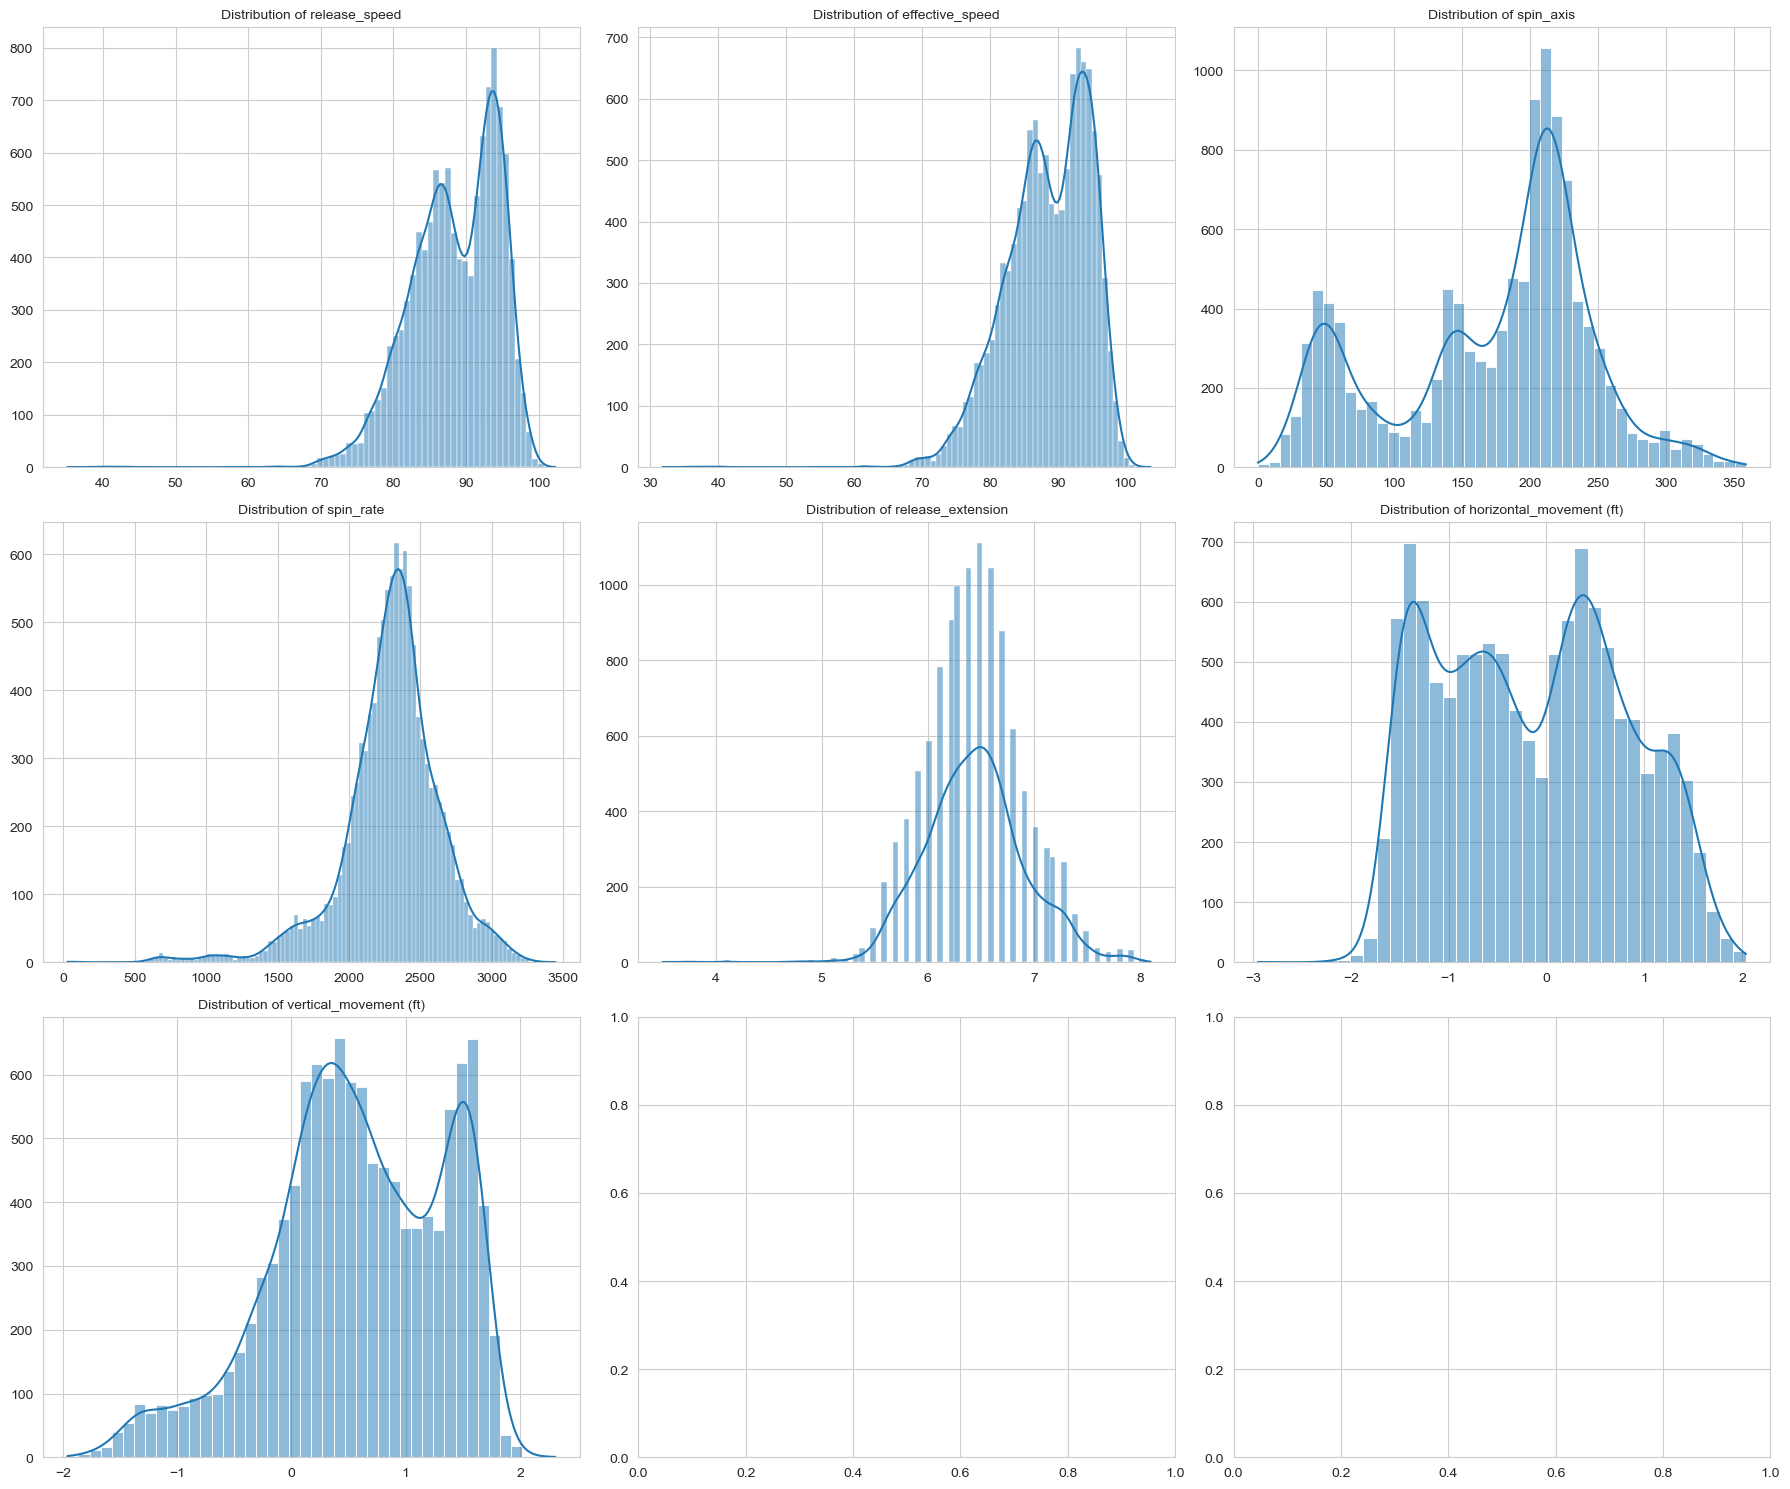

c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


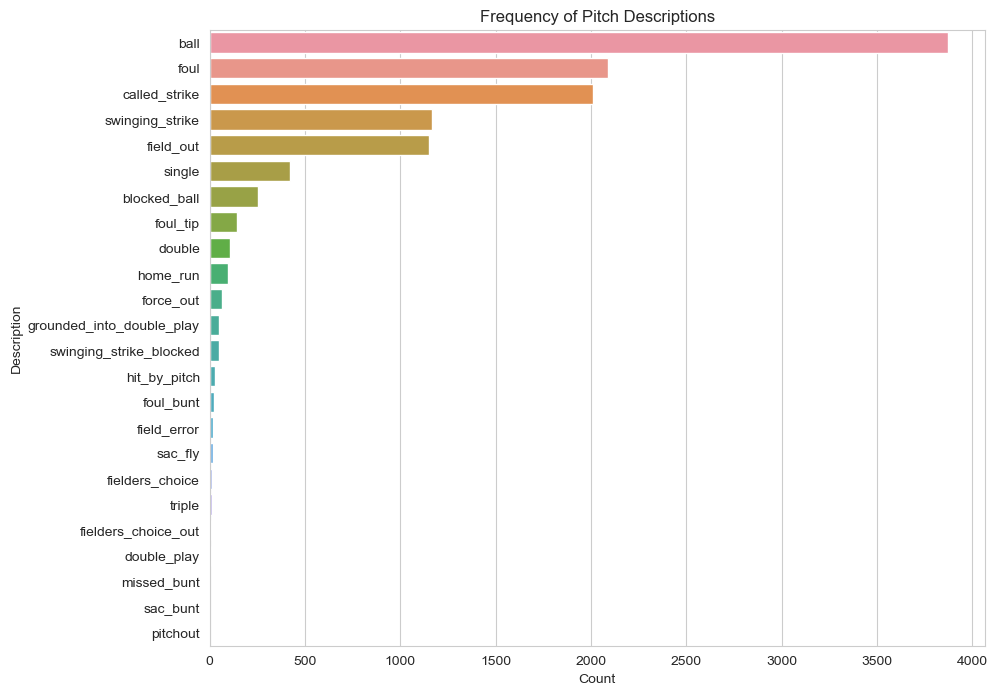

In [265]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the visualizations
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# List of numeric columns to plot
numeric_columns = ['release_speed', 'effective_speed', 'spin_axis', 'spin_rate', 'release_extension', 'horizontal_movement (ft)', 'vertical_movement (ft)']

# Plot histograms for numeric columns
for ax, column in zip(axes.flatten(), numeric_columns):
    sns.histplot(df_pitches_compact[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Tight layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

# Plot the count of the target variable 'description'
plt.figure(figsize=(10, 8))
sns.countplot(y='description', data=df_pitches_compact, order=df_pitches_compact['description'].value_counts().index)
plt.title('Frequency of Pitch Descriptions')
plt.xlabel('Count')
plt.ylabel('Description')
plt.show()

c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future 

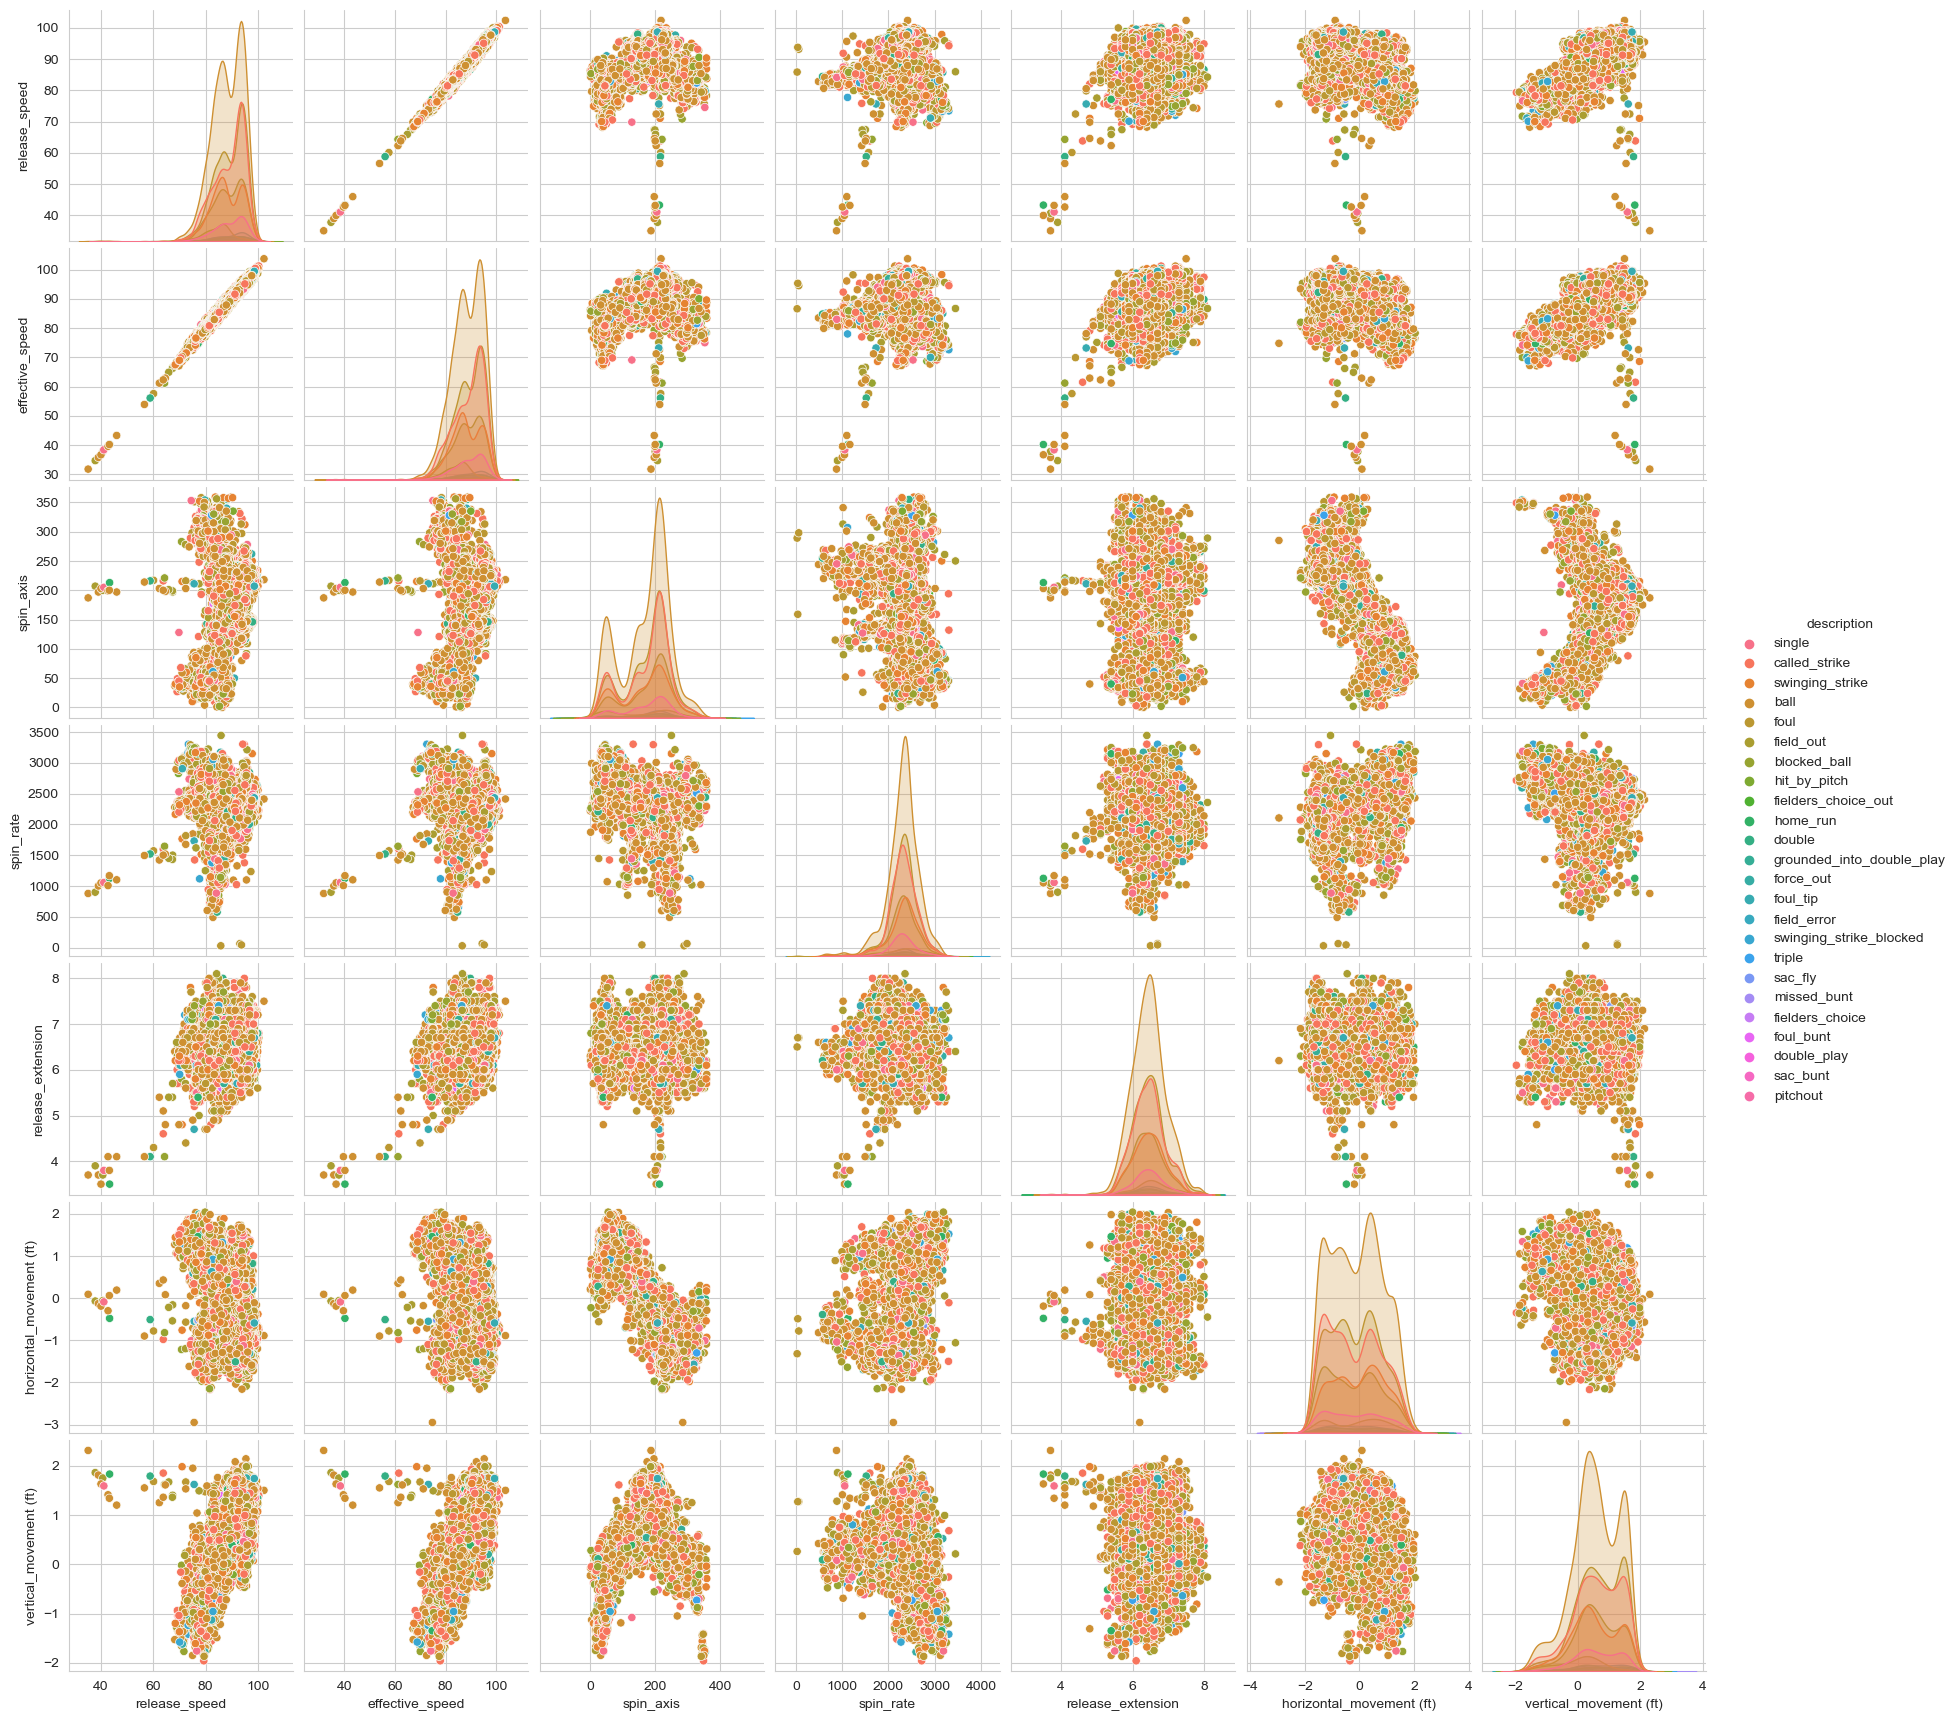

In [266]:
# Pairplot of the DataFrame to visualize the relationships between all pairs of variables
sns.pairplot(df_pitches_compact, hue='description')
plt.show()

c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future 

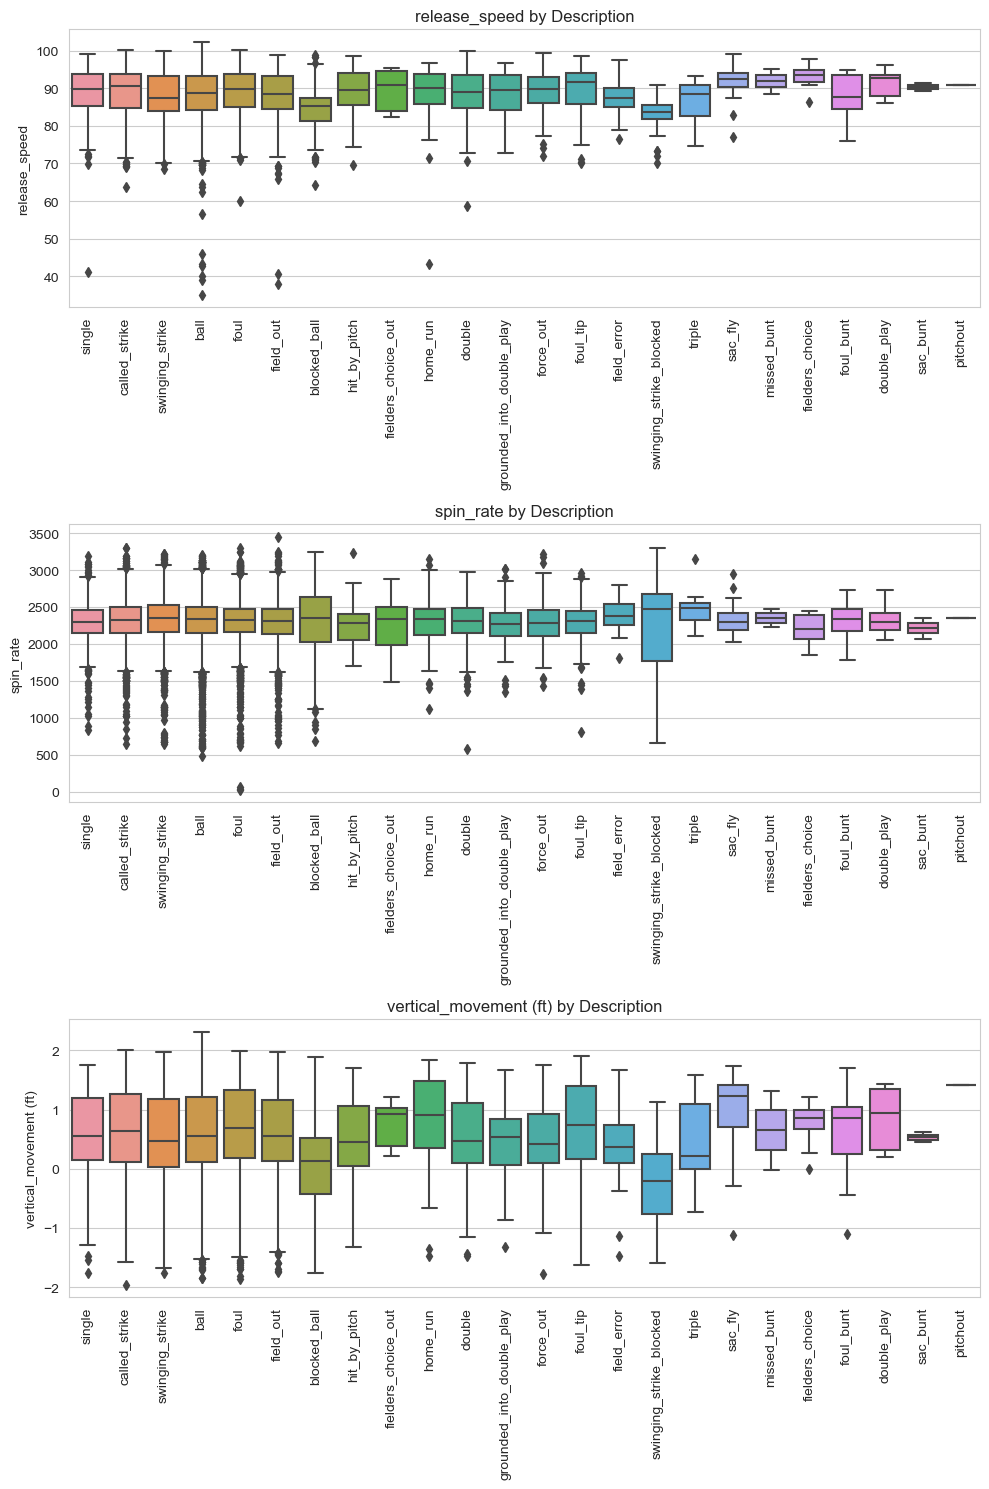

In [267]:
# Create box plots for a few selected numeric features against the target variable 'description'
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Selected features for detailed examination against the target variable
selected_features = ['release_speed', 'spin_rate', 'vertical_movement (ft)']

for ax, feature in zip(axes, selected_features):
    sns.boxplot(x='description', y=feature, data=df_pitches_compact, ax=ax)
    ax.set_title(f'{feature} by Description')
    ax.set_xlabel('')
    ax.set_ylabel(f'{feature}')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\810cl\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


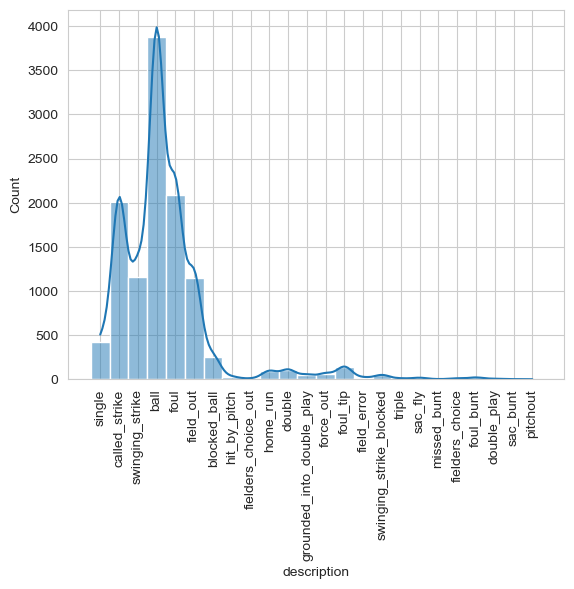

In [268]:
sns.histplot(df_pitches_compact['description'], bins=10, kde=True) # create a histogram of the 'description' column to visualize the distribution of pitch types
plt.xticks(rotation=90) # rotate the x-axis labels for better readability
plt.show()

In [269]:
df_pitches_compact['description'] = df_pitches_compact['description'].astype('category') # convert the 'description' column to a categorical data type
df_pitches_compact['pitch_type'] = df_pitches_compact['pitch_type'].astype('category') # convert the 'pitch_type' column to a categorical data type
df_pitches_compact['pitcher_handedness'] = df_pitches_compact['pitcher_handedness'].astype('category') # convert the 'pitcher_handedness' column to a categorical data type
df_pitches_compact.info() # verify that the data types of the columns have been updated

<class 'pandas.core.frame.DataFrame'>
Index: 11599 entries, Bello, Brayan to Burnes, Corbin
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   pitch_type                11599 non-null  category
 1   release_speed             11599 non-null  float64 
 2   effective_speed           11599 non-null  float64 
 3   spin_axis                 11599 non-null  float64 
 4   spin_rate                 11599 non-null  float64 
 5   release_extension         11599 non-null  float64 
 6   pitcher_handedness        11599 non-null  category
 7   horizontal_movement (ft)  11599 non-null  float64 
 8   vertical_movement (ft)    11599 non-null  float64 
 9   description               11599 non-null  category
dtypes: category(3), float64(7)
memory usage: 1018.5+ KB


In [270]:
df_pitches_c = pd.get_dummies(df_pitches_compact, dtype=int) # create dummy variables for the categorical columns in the DataFrame

In [271]:
df_pitches_compact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11599 entries, Bello, Brayan to Burnes, Corbin
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   pitch_type                11599 non-null  category
 1   release_speed             11599 non-null  float64 
 2   effective_speed           11599 non-null  float64 
 3   spin_axis                 11599 non-null  float64 
 4   spin_rate                 11599 non-null  float64 
 5   release_extension         11599 non-null  float64 
 6   pitcher_handedness        11599 non-null  category
 7   horizontal_movement (ft)  11599 non-null  float64 
 8   vertical_movement (ft)    11599 non-null  float64 
 9   description               11599 non-null  category
dtypes: category(3), float64(7)
memory usage: 1018.5+ KB


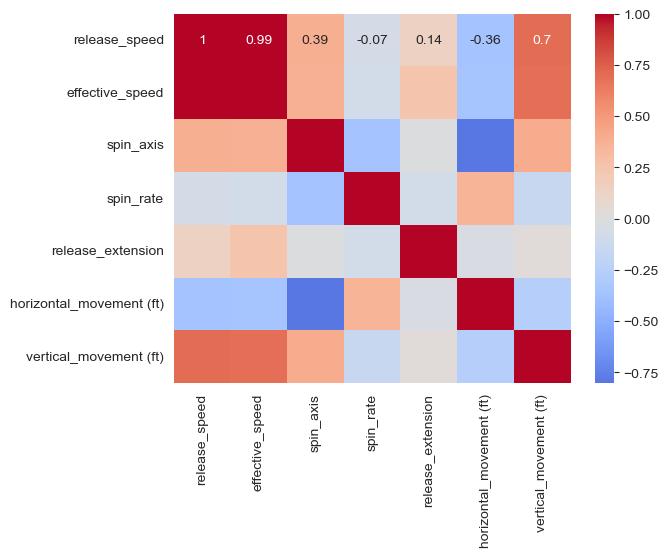

In [272]:
# Create a heatmap of the correlation matrix to visualize the relationships between all pairs of variables
sns.heatmap(df_pitches_compact.select_dtypes(include='float').corr(), annot=True, cmap='coolwarm', center=0) # create a heatmap of the correlation matrix
plt.show()

In [273]:
df_pitches_dummies.corr()

,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FS,pitch_type_KC,pitch_type_PO,pitch_type_SI,...,description_hit_by_pitch,description_home_run,description_missed_bunt,description_pitchout,description_sac_bunt,description_sac_fly,description_single,description_swinging_strike,description_swinging_strike_blocked,description_triple
pitch_type_CH,1.000000,-0.091128,-0.009599,-0.016074,-0.134011,-0.194308,-0.052971,-0.038153,-0.003034,-0.143030,...,-0.004173,0.003034,-0.004291,-0.003034,-0.004291,-0.012882,-0.014746,0.014291,0.014735,-0.009599
pitch_type_CU,-0.091128,1.000000,-0.008192,-0.013719,-0.114373,-0.165834,-0.045208,-0.032562,-0.002590,-0.122070,...,0.006650,-0.006627,-0.003662,-0.002590,-0.003662,-0.002530,-0.016491,0.013311,0.028070,0.014513
pitch_type_EP,-0.009599,-0.008192,1.000000,-0.001445,-0.012047,-0.017468,-0.004762,-0.003430,-0.000273,-0.012858,...,-0.001445,0.030108,-0.000386,-0.000273,-0.000386,-0.001158,0.010056,-0.009811,-0.001913,-0.000863
pitch_type_FA,-0.016074,-0.013719,-0.001445,1.000000,-0.020174,-0.029252,-0.007974,-0.005744,-0.000457,-0.021532,...,-0.002420,-0.004446,-0.000646,-0.000457,-0.000646,-0.001939,-0.009523,-0.010582,-0.003204,-0.001445
pitch_type_FC,-0.134011,-0.114373,-0.012047,-0.020174,1.000000,-0.243872,-0.066482,-0.047885,-0.003808,-0.179514,...,-0.005161,-0.004202,0.013318,-0.003808,0.032021,0.008787,-0.009643,0.006873,-0.026712,-0.003680
pitch_type_FF,-0.194308,-0.165834,-0.017468,-0.029252,-0.243872,1.000000,-0.096396,-0.069430,-0.005522,-0.260286,...,-0.005257,0.025051,-0.007809,-0.005522,-0.007809,0.026414,0.000573,-0.014416,-0.038731,0.002592
pitch_type_FS,-0.052971,-0.045208,-0.004762,-0.007974,-0.066482,-0.096396,1.000000,-0.018927,-0.001505,-0.070957,...,-0.007974,-0.008565,-0.002129,-0.001505,-0.002129,-0.006391,0.009569,0.036685,0.039934,-0.004762
pitch_type_KC,-0.038153,-0.032562,-0.003430,-0.005744,-0.047885,-0.069430,-0.018927,1.000000,-0.001084,-0.051108,...,-0.005744,-0.010554,-0.001533,-0.001084,-0.001533,0.014411,-0.002548,-0.014087,0.038554,-0.003430
pitch_type_PO,-0.003034,-0.002590,-0.000273,-0.000457,-0.003808,-0.005522,-0.001505,-0.001084,1.000000,-0.004064,...,-0.000457,-0.000839,-0.000122,1.000000,-0.000122,-0.000366,-0.001798,-0.003101,-0.000605,-0.000273
pitch_type_SI,-0.143030,-0.122070,-0.012858,-0.021532,-0.179514,-0.260286,-0.070957,-0.051108,-0.004064,1.000000,...,0.026295,-0.000299,0.012127,-0.004064,-0.005748,-0.005332,0.029720,-0.071987,-0.028510,-0.004861


As you can see below the data is not balanced. It is right skewed data. The top 3 most apperaed outcome/description is Ball, Called Strike, and Foul.

As you can see above, the most outliers are in the Ball, Called Strike, and Foul. This makes sense because these are the most common outcomes in this dataset and they have the most data points. Hence, it is normal to see more outliers in these categories.

When looking at the target variable we found that there were a large number of outcomes for the target variable; however these outcomes boiled down to four main true outcomes. There were many different types of balls that were tracked, but each of these types of balls have had the same game outcome. The same was true of strikes, which come in large large variety from called strikes to swinging strikes to foul balls. All of these outcomes have the same effect on the game so we grouped them together. Similarly, for field outs it does not matter the way in which the out is recorded the outcome is all the same, so we grouped them together. Finally, we decided to group hits together, since although they have a slightly different effect on the pitcher, they represent the same effect as the pitcher has allowed a base runner and failed to record an out, so we decided to group them together. The groupings we choose are listed below. 
Categories:

Balls: ball, blocked_ball, hit_by_pitch, pitchout

Strikes: called_strike, swinging_strike, foul, foul_tip, missed_bunt, swinging_strike_blocked, foul_bunt 

Hits: single, double, triple, home_run

Field Outs: sac_bunt, fielders_choice_out, fielders_choice, sac_fly, field_error, force_out, field_out

In [274]:
if 'hit' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('hit')
if 'field_error' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('field_out')
if 'strike' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('strike')
if 'ball' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('ball')
for index, row in df_pitches_description.iterrows():
    if row['description'] == 'ball' or row['description'] == 'blocked_ball' or row['description'] == 'hit_by_pitch' or row['description'] == 'pitchout':
        df_pitches_description.at[index, 'description'] = 'ball'
    elif row['description'] == 'called_strike' or row['description'] == 'swinging_strike' or row['description'] == 'foul' or row['description'] == 'foul_tip' or row['description'] == 'missed_bunt' or row['description'] == 'swinging_strike_blocked' or row['description'] == 'foul_bunt':
        df_pitches_description.at[index, 'description'] = 'strike'
    elif row['description'] == 'single' or row['description'] == 'double' or row['description'] == 'triple' or row['description'] == 'home_run':
        df_pitches_description.at[index, 'description'] = 'hit'
    else:
        df_pitches_description.at[index, 'description'] = 'field_out'
df_pitches_description['description'].value_counts()


description
strike                       6302
ball                         4362
field_out                     619
hit                           316
called_strike                   0
home_run                        0
triple                          0
swinging_strike_blocked         0
swinging_strike                 0
single                          0
sac_fly                         0
sac_bunt                        0
pitchout                        0
missed_bunt                     0
hit_by_pitch                    0
double                          0
blocked_ball                    0
foul_tip                        0
foul_bunt                       0
foul                            0
force_out                       0
fielders_choice_out             0
fielders_choice                 0
field_error                     0
double_play                     0
grounded_into_double_play       0
Name: count, dtype: int64

# Modeling Outcomes

In your final cells, discuss the modeling methods you expect to use. Start by clearly explaining if 
this is a classification, regression, clustering, or association rule mining problem? Justify.
* We have not covered every possible method out there. But, you have much of the 
framework to apply most algorithms, even those beyond what we covered in class. Feel 
free to explore different methods if you have good justification for doing so.
* If there are any papers of significance that have been published with these data, then 
discuss the ones most interesting / relevant to the team

# Project Aims

 Finally, what is your overarching aim with this project? What are you hoping to learn? Or, what 
hypothesis are using the data to confirm or disprove? What challenges do you foresee on this 
project? Discuss your concerns. How will you get your work done? Give a reasonable list of 
milestones to reach to arrive at the final deadline for the project.